# House Price Prediction 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Regression Problem

Models 
Lasso Regression, Ridge Regression, Random Forest, XGBoost, SVR, and Kernel Ridge.  

Steps:

1. Data Cleaning, drop the feature if more than 95% of the feature values are NANs, 0, or no variance. 

2. Fill in the missing data. If categorical variable, fill in ‘None’. If numeric variable, fill in “0” or median depending on the case. 

3. Label encoding. Categorical variable has to be converted to numeric values in the preprocessing. If ordinal variable (e.g., ‘Ex’,’Gd’,’Ta’,’Fa’,’Po’), use label encoder. For nominal variable (e.g., ‘male’, ‘female’), use one-hot encoding to create dummy variables. 

4. Feature selection. Assuming the linear relationship, checked the statistic p_value (adjusted R^2 value). Use Lasso Regression for the feature selection (because the coefficient can be zeros, means no contribution to the model). 

5. Modeling. Kernel Ridge Regression works the best. 

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import house_functions
import importlib
importlib.reload(house_functions)
from house_functions import * # self-defined 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from scipy import stats

In [53]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
print('Length of trainning', len(train))
print('Length of test', len(test))
# combine train and test data 
df=pd.concat([train,test], axis=0,sort=False).reset_index(drop=True) 
# combine training and test 

df = df.drop(columns=['SalePrice'])
print('Total Data Shape',df.shape)

Length of trainning 1460
Length of test 1459
Total Data Shape (2919, 80)


In [54]:
nan=pd.isnull(df).sum().sort_values(ascending=False).head(3) # drop if too many NaNs (>95%)
dropcol=[col for col in nan.axes[0]]

for col in df.columns:   # if too many zeros
    if df[col].dtype==np.int64:
        if (df[col]==0).sum() >=2919*0.95:
            dropcol.append(col)
    if df[col].dtypes == np.object:
        a=df.groupby(col).count()
        if a.Id.max()>=2919*0.95:  # which means 90% of the information are the same 
            dropcol.append(col)

dropcol.append('Id')
df_clean=df.drop(columns=dropcol,axis=1)
print('data size after clean', df_clean.shape)

data size after clean (2919, 66)


In [55]:
categorical_col = df_clean.select_dtypes(include=[np.object]).columns
N=pd.isnull(df_clean).sum().sort_values(ascending=False).head(30) 

print([x for x in N.axes[0] if x in df_clean.select_dtypes(include=[np.number]).columns])

['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']


### Fill in the missing data and encode catergory data
Catergorical Data Types: ordinal & nominal; for ordinal type, use label encoded. 


In [56]:
# Category features fill in the missing data 
for col in categorical_col:
    df_clean[col]=df_clean[col].fillna('None')
    
# Numeric features        
for col in ('GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageCars',\
            'GarageArea','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF'):
    df_clean[col] = df_clean[col].fillna(0)   

#col=data.columns
df_clean.GarageYrBlt.fillna(2100,inplace=True)
df_clean["LotFrontage"] = df_clean.groupby("Neighborhood")["LotFrontage"].transform(\
    lambda x: x.fillna(x.median()))

ordinal_c=['ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu',\
           'GarageQual','GarageCond','GarageFinish',\
          'BsmtExposure','BsmtCond','BsmtQual']


codes = {'Gd':4,'TA':3,'Ex':5,'Fa':2,'Po':1,'None':0}
for col in ['ExterQual','ExterCond','HeatingQC','FireplaceQu','KitchenQual']:
    df_clean[col] = df_clean[col].map(codes)

codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
df_clean['BsmtQual'] = df_clean['BsmtQual'].map(codes)
df_clean['BsmtCond'] = df_clean['BsmtCond'].map(codes)

codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
df_clean['GarageQual'] = df_clean['GarageQual'].map(codes)
df_clean['GarageCond'] = df_clean['GarageCond'].map(codes)

codes = {'Gd':4, 'Av':3, 'Mn':2, 'No':1,'None':0}
df_clean['BsmtExposure'] = df_clean['BsmtExposure'].map(codes)

codes = {'Fin':3,'RFn':2,'Unf':1,'None':0}
df_clean['GarageFinish'] = df_clean['GarageFinish'].map(codes)

numeric_col = df_clean.select_dtypes(include=[np.number]).columns

# get the dummy 
dummy=list(set(categorical_col)-set(ordinal_c))
df_clean = pd.get_dummies(df_clean, columns=dummy)

In [57]:
df_clean.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,...,0,0,0,0,0,0,0,0,0,1


### Check the skewness 

why? because in linear regression, y = beta*x + eps; we assume eps is Normal Distribution, linearity -- y Normal Distribution 


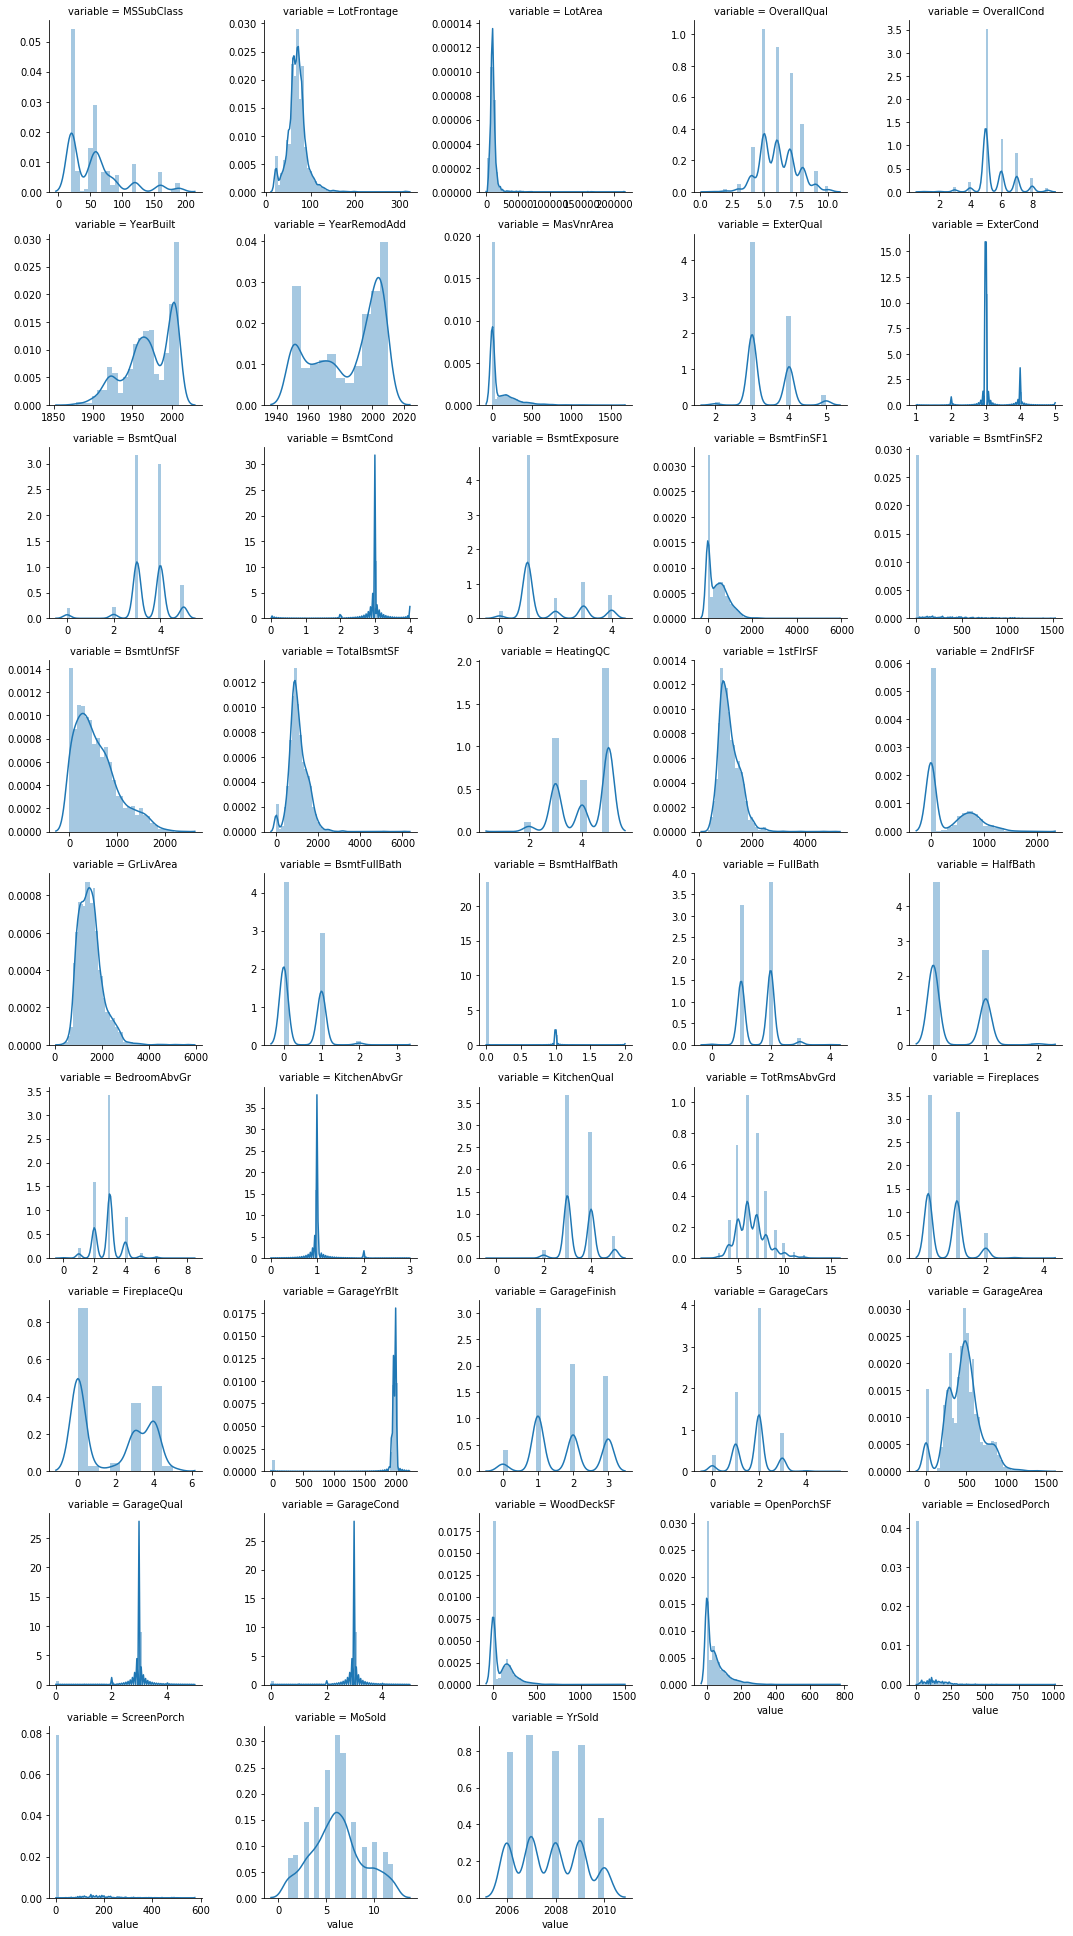

In [58]:
## visualize the distribution again
temp = pd.melt(df_clean, value_vars=numeric_col)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , height=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

In [60]:
# Check the skew of all numerical features 
# Does it matter? Yes. 
from scipy.stats import norm, skew
skewed_feats = df_clean[numeric_col].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
#skewness.head(5)

skewness = skewness[abs(skewness) > 1.0]
skewed_features = skewness.index
#lam = 0.25
#from scipy.special import boxcox1p
for col in skewed_features:
    df_clean[col] = np.log1p(df_clean[col])

### Standardization (or Z-score normalization)

In [61]:
train_X = df_clean[:(len(train))]
train_y = train['SalePrice'] 
train_y = np.log1p(train_y)

In [62]:
# feature normalization 
xscaler = StandardScaler()
yscaler = StandardScaler()

train_X_std=train_X.copy()
train_y_std=train_y.copy()

train_X_std[numeric_col] = (xscaler.fit_transform(train_X[numeric_col]))
train_y_std = yscaler.fit_transform(train_y.values.reshape((len(train_y), 1))) # series data 

y=pd.DataFrame(train_y_std,columns=['SalePrice'])['SalePrice']
X=train_X_std
print('Training Set', X.shape, y.shape) 

Training Set (1460, 219) (1460,)


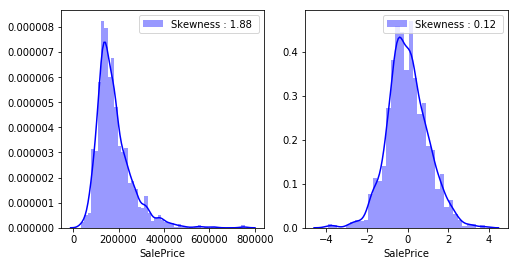

In [63]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
g = sns.distplot(train['SalePrice'], color="b", label="Skewness : %.2f "\
                %(train['SalePrice'].skew()), ax=ax[0])
g = g.legend(loc="best")

g = sns.distplot(y, color="b", label="Skewness : %.2f "\
                %(y.skew()),ax=ax[1])
g = g.legend(loc="best")

### Models 
1. Statitics (R; p_value) Check if linear regression is a good assumption.  

In [64]:
X2 = sm.add_constant(X)
est = sm.OLS(y.values, X2)
est2 = est.fit()
#print(est2.summary())

 ### Machine Learning Methods
 
 ### Metrics: rmse
 
 Applied Cross Validation since the dataset is not very big. 

In [65]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

### Lasso Regression

Parameter Tuning 

In [66]:
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import GridSearchCV

alpha_range = np.linspace(0.003,0.01,10)
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alpha_range),scoring='neg_mean_absolute_error')
grid.fit(X,y)
print(grid.best_estimator_.alpha)

0.003


In [67]:
La = LassoCV(alphas=[0.003]) # find the best fitting alpha
La.fit(X, y)
predictions = La.predict(X)

RMSE 0.29876181980066474
Cross Validation Lasso Regression   0.31978560969642045


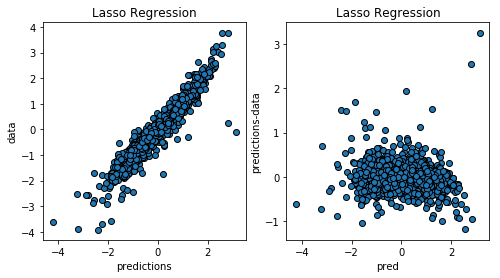

In [68]:
print_model_results(La,'Lasso Regression',kfold,y,predictions,X)
plot_scatter(predictions,y,'Lasso Regression')

In [69]:
#(list(zip(model.coef_,X[features.index.values[1:]])))
lasso_feature = X.columns
print(len(lasso_feature[La.coef_ != 0]))
feature_new=lasso_feature[La.coef_ != 0]

64


Use Lasso find new features (the coefficient not 0)

In [70]:
X_new = X[feature_new]

### Ridge Regression

In [71]:
# find the best alpha parameter 
from sklearn.linear_model import Ridge,RidgeCV
alpha_range=np.linspace(0.5,10,10)
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alpha_range),scoring='neg_mean_absolute_error')
grid.fit(X_new,y)
print(grid.best_estimator_.alpha)

5.777777777777778


In [72]:
Rg = Ridge(alpha=[6])
Rg.fit(X_new, y) 
predictions=Rg.predict(X_new)

RMSE 0.2892826818154883
Cross Validation Ridge Regression   0.30772630986084526


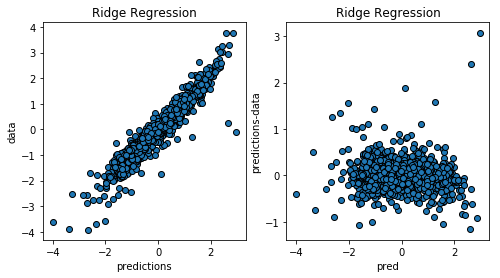

In [73]:
print_model_results(Rg,'Ridge Regression',kfold,y,predictions,X_new)
plot_scatter(predictions,y,'Ridge Regression')

### Random Forest
Bagging of Decision Tree 

In [74]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_new, y)
predictions = rf.predict(X_new)

RMSE 0.12696611237404362
Cross Validation RF Regression   0.3480764101896322


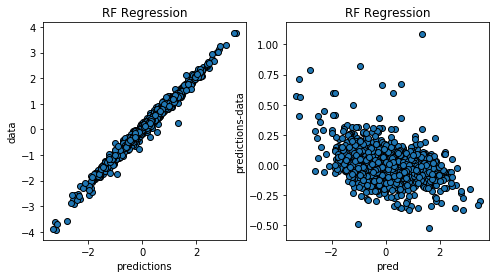

In [23]:
print_model_results(rf,'RF Regression',kfold,y,predictions,X_new)
plot_scatter(predictions,y,'RF Regression')

### XGBoost 
Boosting of Decision Trees  

In [75]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=2000, learning_rate=0.05, gamma=0, subsample=0.75,\
                           colsample_bytree=1, max_depth=3)
xgb.fit(X_new,y)
predictions = xgb.predict(X_new)

RMSE 0.0583725680785292
Cross Validation XGB Regression   0.29489672175381104


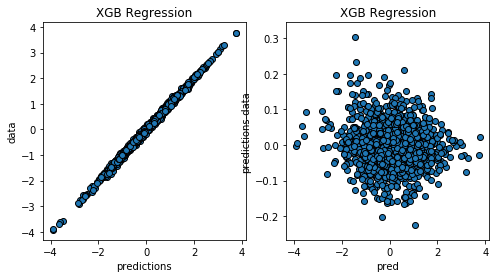

In [76]:
print_model_results(xgb,'XGB Regression',kfold,y,predictions,X_new)
plot_scatter(predictions,y,'XGB Regression')

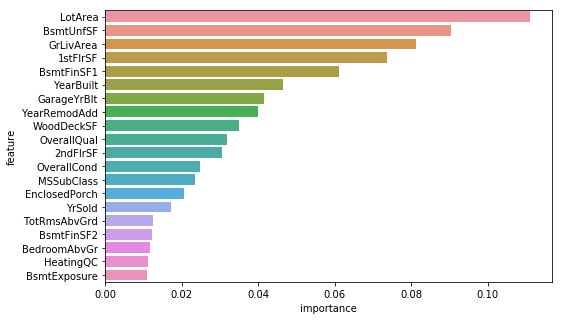

In [77]:
importances = list(xgb.feature_importances_) ; feature_list = list(X_new.columns)
feature_importances = [(feature, importance) for feature, importance in \
                       zip(feature_list, importances)]
feature_importances = pd.DataFrame(feature_importances, columns=['feature','importance'])

feature_importances = feature_importances.sort_values(['importance'],\
                        ascending=False).reset_index(drop=True)

plt.subplots(figsize=(8, 5))
sns.barplot(y='feature', x='importance',data=feature_importances.iloc[:20])

### SVR

In [80]:
from sklearn.svm import SVR,LinearSVR
C_range=np.linspace(0.5,5,5)
model = SVR()
grid = GridSearchCV(estimator=model, param_grid=dict(C=C_range))
grid.fit(X_new,y)
print(grid.best_estimator_.C)

2.75


RMSE 0.17151299857112956
Cross Validation SVR   0.31971565360004484


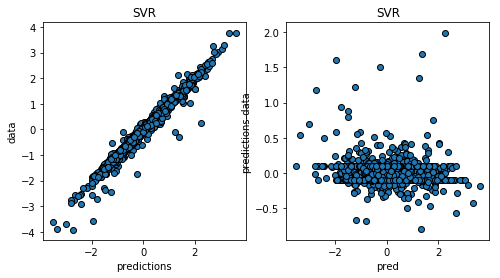

In [85]:
sv = SVR(C=3)
sv.fit(X_new, y)
predictions = sv.predict(X_new)
print_model_results(sv,'SVR',kfold,y,predictions,X_new)
plot_scatter(predictions,y,'SVR')

### Kernel Ridge

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import uniform

ridge = KernelRidge()
parameters = {'alpha': uniform(0.05, 1.0), 'kernel': ['polynomial'], 
              'degree': [2], 'coef0':uniform(0.5, 3.5)}
random_search = RandomizedSearchCV(estimator = ridge,
                                   param_distributions = parameters,
                                   n_iter = 1000,
                                   scoring = 'neg_mean_absolute_error',
                                   random_state=0)

random_search = random_search.fit(X_new, y)

In [30]:
print("Parameters of the best_estimator:")
print(random_search.best_params_)

Parameters of the best_estimator:
{'alpha': 0.6808318084098038, 'coef0': 3.992979003274805, 'degree': 2, 'kernel': 'polynomial'}


RMSE 0.220704869724583
Cross Validation kernelridge   0.28966841912556934


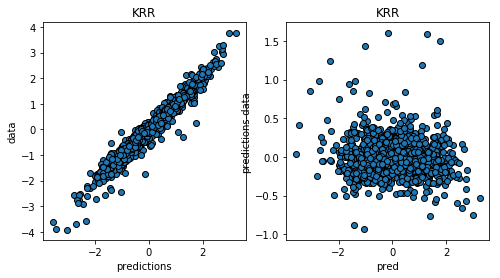

In [43]:
krr = KernelRidge(alpha=0.6808,coef0=3.993,degree=2,kernel='polynomial')
krr.fit(X_new, y)
predictions = krr.predict(X_new)

print_model_results(krr,'kernelridge',kfold,y,predictions,X_new)
plot_scatter(predictions,y,'KRR')

### Evaluate ML Algorithms: Learning Curves

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

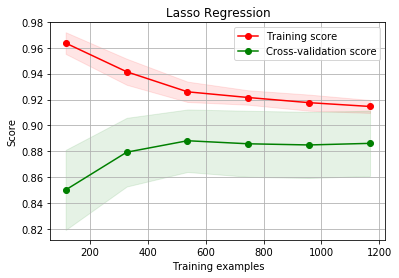

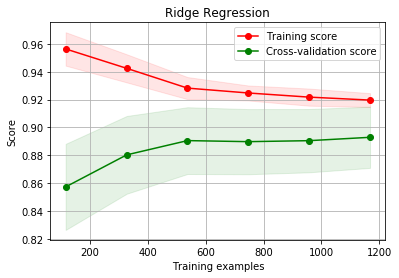

In [33]:
#from house_functions import * 
from sklearn.model_selection import ShuffleSplit

title = "Lasso Regression"
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)
estimator = La
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

title = "Ridge Regression"
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)
estimator = Rg
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

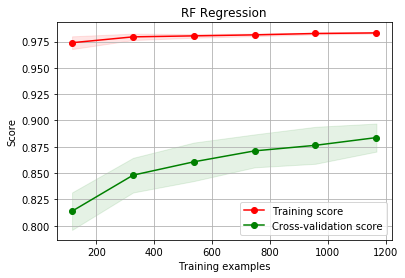

In [34]:
title = "RF Regression"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = rf
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

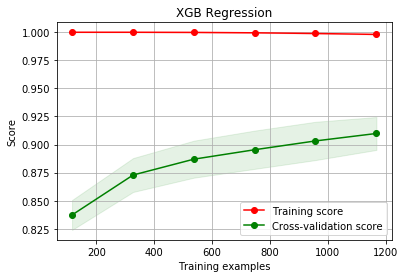

In [35]:
title = "XGB Regression"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

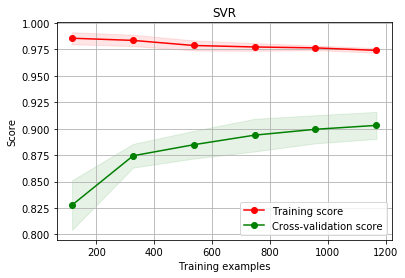

In [36]:
title = "SVR"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = sv
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

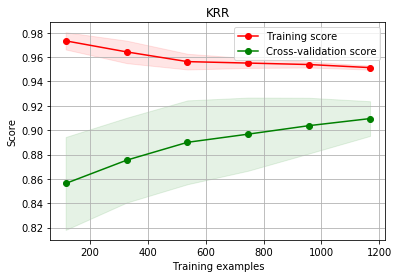

In [37]:
title = "KRR"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = krr
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

### Predictions: stacking 

In [38]:
# test data 
test_X=df_clean[(len(train)):]
test_X_std=test_X.copy()
test_X_std[numeric_col] = xscaler.transform(test_X[numeric_col])

In [39]:
pred_rr=Rg.predict(test_X_std[feature_new])
pred_La=La.predict(test_X_std)
pred_xgb=xgb.predict(test_X_std[feature_new])
pred_sv=sv.predict(test_X_std[feature_new])
pred_krr=krr.predict(test_X_std[feature_new])

In [40]:
#pred=(pred_rr+pred_sv+pred_xgb+pred_krr)/4.0
pred=(pred_krr+pred_La)/2.0  # best 

In [41]:
Y_pred=yscaler.inverse_transform(pred)
Y_pred=np.expm1(Y_pred)
print(np.mean(Y_pred), np.mean(np.expm1(yscaler.inverse_transform(y))))

177488.29303924294 180921.19589041095


In [42]:
submission=pd.DataFrame(
    {'Id': test.Id,
     'SalePrice': Y_pred
    })
submission.to_csv('submission.csv', index=False)

Scored 0.11746